# RCT2 Problem Solution

[Last time](/2020/08/12/roller-coaster-tycoon-problem.html), we discussed the RCT2 problem, which we won't delve into in great detail, but at a high level, we have an inductively defined Markov chain, parameterized by $n$, with special start and end states and the following outgoing arrows, such that for $k\in[n]$, we have the following transition dynamics:

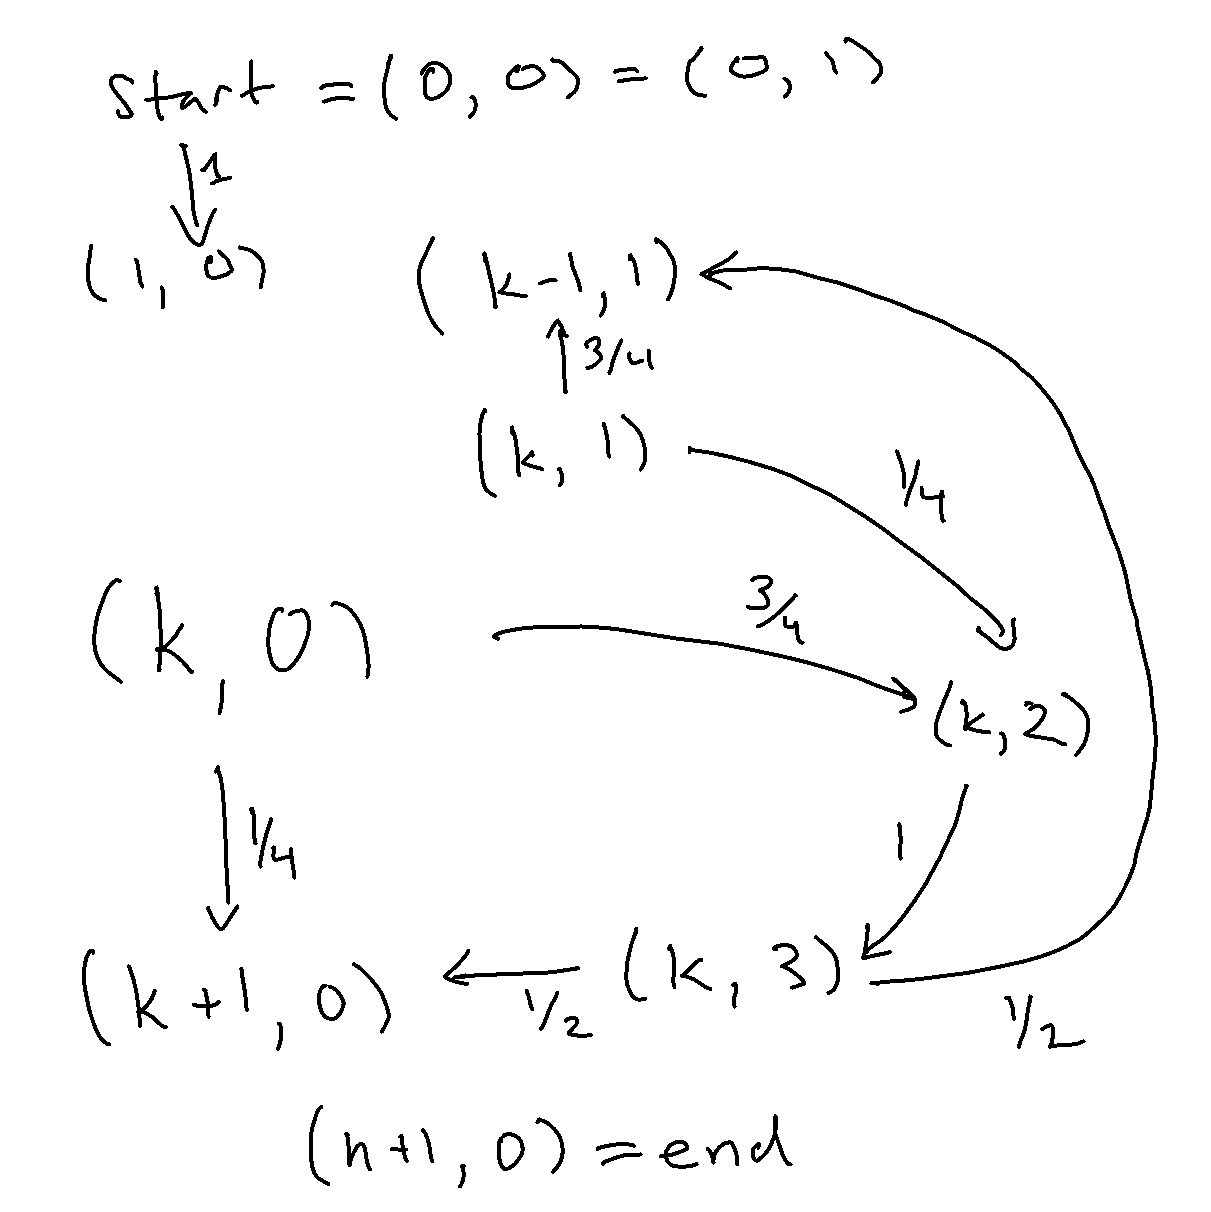

In [1]:
from IPython.display import Image
Image(filename='transitions.png') 

We already went over how to solve the expected hitting time for the end state for a given, known $n$. We now focus on how to solve for a parameter $n$.

We'll go about solving this "by hand" as we would in a class, but then think about deeper implications.

If we use our intuition from the video in the previous post, we'll notice that there are two modalities of transitioning between states. You're either moving backwards or forwards, and you have some slight momentum in both directions (but the momentum is stronger going backwards).

In particular, let's introduce two random variables, which are well-defined by the Markov property. Namely, the expected time to reach the end from a given state is a function of the state you're in and not any other history of your maze exploration. 

So, meet $F_k$, the expected time to reach the end when you're facing forward (towards the exit) in the $k$-th tile.

And then there's $B_k$, the expected time to reach the end when you're facing backwards (towards the enterance) in the $k$-th tile.

By exploring all our local transitions described above, we can do one "value iteration." In particular, the following must hold:
$$
\begin{align}
F_0&=B_0\\
B_0&=1+F_1\\
F_k&=\frac{1}{4}(1+F_{k+1})+\frac{3}{8}(3+B_{k-1})+\frac{3}{8}(3+F_{k+1})\\
B_k&=\frac{3}{4}(1+B_{k-1})+\frac{1}{8}(3+B_{k-1})+\frac{1}{8}(3+F_{k+1})\\
F_{n+1}&=0\,\,.
\end{align}
$$
The middle equations are the juicy ones, but they just internalize the transition into the $(k, 2)$ state. In other words, for $F_k$, wp $\frac{1}{4}$ we keep moving forward (costing us a single time step), but wp $\frac{3}{4}$ we go into the inlet $(k, 2)$, after which we go to $(k, 3)$ and then split our probability mass between going back up or down. $B_k$ is similar, but note that this equation only holds for $k\in[n-1]$, whereas the $F_k$ equation holds for $k\in[n]$ (from the diagram, you can see that $B_n$ never gets visited).

Simplifying a little, and cleaning up the edge cases, we're left with
$$
\begin{align}
F_0&=B_0\\
B_0&=1+F_1\\
F_k&=\frac{5}{2}+\frac{5}{8}F_{k+1}+\frac{3}{8}B_{k-1}\\
B_k&=\frac{3}{2}+\frac{7}{8}B_{k-1}+\frac{1}{8}F_{k+1}\\
F_n&=\frac{5}{2}+\frac{3}{8}B_{n-1}\\
\end{align}
$$

Now the above equations hold for all $k\in[n-1]$.

It may seem like we have no base case, but it's hiding in there as conservation of mass. By inspecting the final $n$ state, it's clear we'll need some kind of message passing in terms of $(B_{k-1},F_k)$ pairs, and rearranging the equations that's just what we get (i.e., if we had to canonically order our terms $F_0,B_0,F_1,B_1\cdots$, this would correspond to finding a reduced row-echelon form in the large linear system described above). We rearrange the $B_k$ equation in terms of $B_{k-1}$, then we use that value to plug into the $B_{k-1}$ term of $F_k$, which indeed puts $B_{k-1},F_k$ in terms of $B_{k},F_{k+1}$. It's at this point that we should switch to sympy.

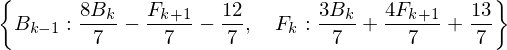

In [2]:
from sympy import *
init_printing()
bkm1, fkm1, bk, fk, fkp1 = symbols('B_{k-1} F_{k-1} B_k F_k F_{k+1}')

eq1 = Eq(fk, S('5/2') + S('5/8') * fkp1 + S('3/8') * bkm1)
eq2 = Eq(bk, S('3/2') + S('7/8') * bkm1 + S('1/8') * fkp1)
sol = solve((eq1, eq2), (bkm1, fk))
sol

Excellent, this confirms what we had written above, and sets us up for a vector recurrence over the vector $(B_k, F_{k+1}, 1)$. Remember, the above equations hold for $k\in[n-1]$.

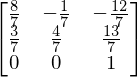

In [3]:
lhs = (bkm1, fk, 1)
rhs = (bk, fkp1, 1)
sol[1] = S('1')

coeffs = [
    sol[v].as_coefficients_dict()
    for v in lhs
]

T = Matrix([[c[v] for v in rhs] for c in coeffs])
T

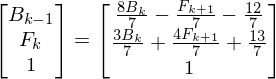

In [4]:
Eq(Matrix(lhs), T * Matrix(rhs))

So now that we have an explicit transition matrix, we can repeat this down to $k-1=0$ (since $k=1\in[n-1]$ is one of the equations this holds for). The trick is that we can unroll the equation by matrix exponentiation, which has closed form for our simple $3\times 3$ matrix. If we were doing this by hand, then we'd need to write out the full eigensystem.

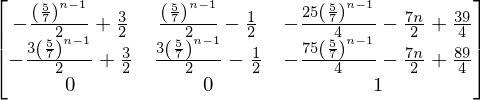

In [5]:
n = symbols('n', positive=True, integer=True)
b0, f1, bnm1, fn = symbols('B_0 F_1 B_{n-1} F_n')
lhs = (b0, f1, 1)
rhs = (bnm1, fn, 1)
T ** (n-1)

Excellent, 2 (effective) equations and 4 unknowns ($B_0,F_1,B_k,B_{n-1},F_n$). Let's re-introduce our original boundary conditions. Then we have our final linear system.

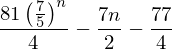

In [6]:
eq1 = Eq(b0, 1+f1)
eq2 = Eq(fn, S('5/2') + S('3/8') * bnm1)
eq3 = Eq(Matrix(lhs), T ** (n-1) * Matrix(rhs))
powsimp(solve((eq1, eq2, eq3), (b0, f1, bnm1, fn))[b0])

And since that is $B_0=F_0$, we have our expected absorption time!

## In Review

What's curious here is that we effectively solved the original formulation of the problem, namely the system $(I-P)\mathbf{x}=\mathbf{1}$, where $P$ is our full transition matrix, using various linear transformations of our equalities. One implicit move was reducing our state space from four states $(k,0)\cdots(k,3)$ to two $F_k,B_k$, but this can just be seen as another substitution of the linear equation relating the expected time to finish the maze from $(k, 2)$ to $(k, 3)$ (which is a simple deterministic equation with the latter exactly 1 larger than the former).

Zooming out a bit, what we ended up doing by "solving out" the $(k, 2)$ and $(k, 3)$ states is simplify into a weighted chain that has the following transitions.

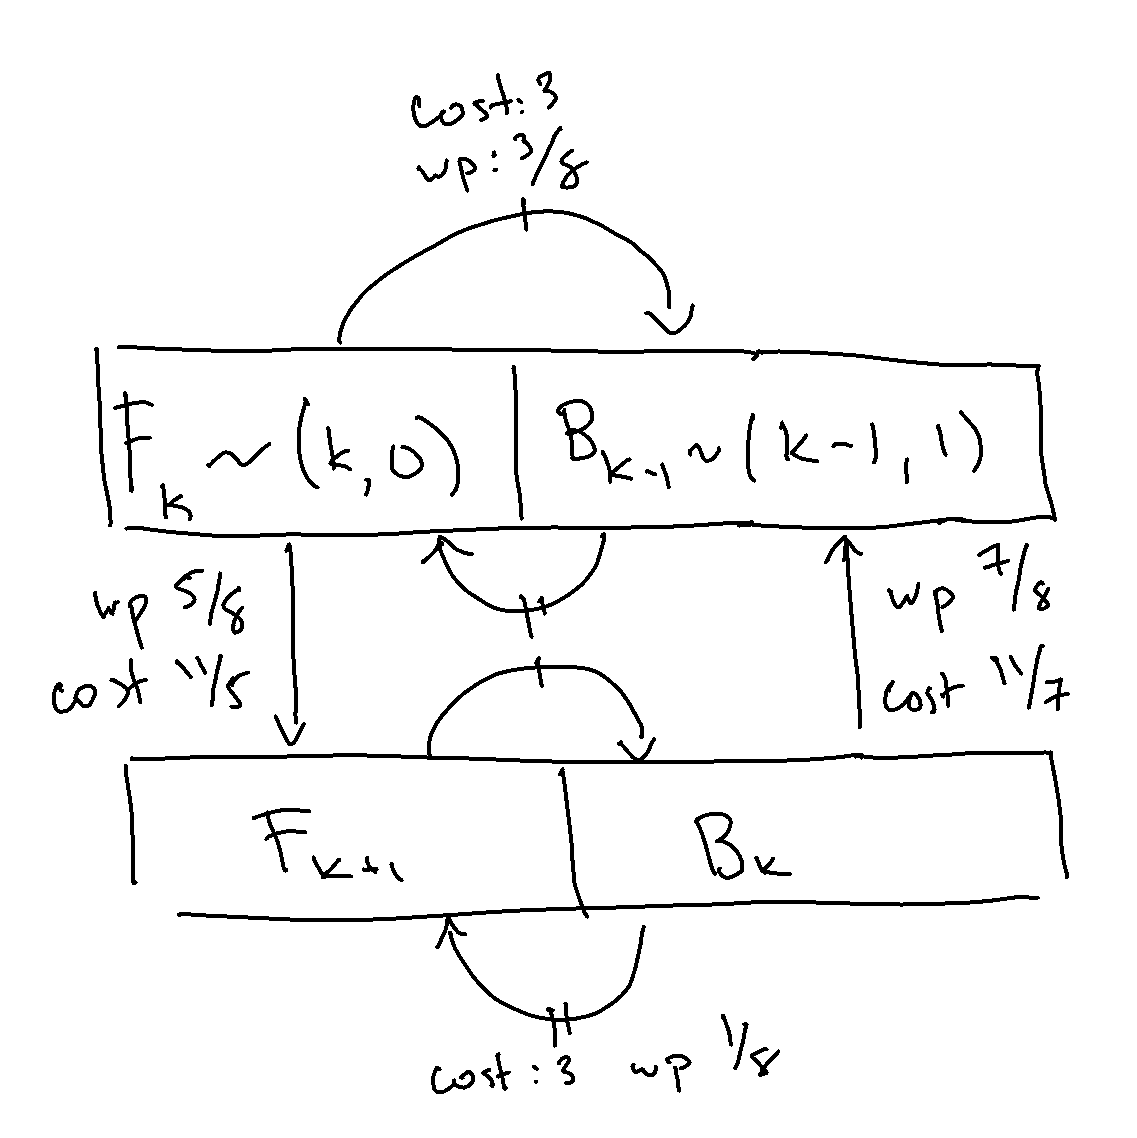

In [7]:
Image(filename='weighted.png') 

What's interesting to me is this transition can be described as some set of elementary transformations $E$ (transforming into $(B_{k-1},F_k)$ space), which simplify the problem $(I-P)\mathbf{x}=\mathbf{1}$ into another one $E(I-P)\mathbf{x}=E\mathbf{1}$ which then happens to be easily reducible, in the sense that $E(I-P)$ becomes a block diagonal matrix with upper-triangular blocks, which is then solved by matrix exponentiation ("backsolving").

This suggests that there's probably an automated method for solving absorption times such inductively-defined Markov chains analytically, but naive analysis of the original $(I-P)$ matrix did not get me very far. Perhaps I'll take a crack at the more generic question another time...